<a href="https://colab.research.google.com/github/kdChen07/progress-and-problems/blob/main/%E6%A3%80%E9%AA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SFCA and RAAM script tests at Middle Layer Super Output Areas (MSOA) level using OSRM distance (30 miles threshold/exclude London)

In [ ]:
!pip install access
!pip install logging
!pip install geopandas
!pip install mapclassify
!pip install legendgram

     |████████████████████████████████| 96 kB 3.5 MB/s 
ERROR: Could not find a version that satisfies the requirement logging (from versions: 0.4.9.6)
ERROR: No matching distribution found for logging
     |████████████████████████████████| 994 kB 7.8 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 47.7 MB/s 


In [ ]:
from access import Access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
#pip install cartopy

# Data import

## Get LA——MSOA code data

In [ ]:
LA_MSOA = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/LA_MSOA_code.csv')
LA_MSOA

,LA_Code_2020,LA_name_2020,MSOA Code
0,E06000001,Hartlepool,E02002483
1,E06000001,Hartlepool,E02002484
2,E06000001,Hartlepool,E02002485
3,E06000001,Hartlepool,E02002487
4,E06000001,Hartlepool,E02002488
...,...,...,...
6786,E09000033,Westminster,E02000979
6787,E09000033,Westminster,E02000980
6788,E09000033,Westminster,E02000981
6789,E09000033,Westminster,E02000982


## Get MSOA boundary data

In [ ]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

## Get the population weighted centroid of MSOA (demand points)

In [ ]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

### Calculate population over 60

In [ ]:
MSOA_points['pop60+69'] = MSOA_points['pop60-69']

In [ ]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop60+69
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (445582.345 524175.434),1132
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (446777.151 524256.841),836
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (461356.929 515118.900),863
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (446117.027 525455.836),1385
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (461053.212 516175.379),810
...,...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (393469.114 227500.260),1156
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (332829.367 109219.836),805
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (343276.340 158947.520),1230
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (331710.269 136880.200),906


## read vaccination site point data (supply points)

In [ ]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

In [ ]:
import requests
import json

In [ ]:
MSOA_points = MSOA_points.to_crs('epsg:4326')
MSOA_points['MSOA_lon'] = MSOA_points['geometry'].x
MSOA_points['MSOA_lat'] = MSOA_points['geometry'].y

In [ ]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop60+69,MSOA_lon,MSOA_lat
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (-1.29577 54.61069),1132,-1.295773,54.610691
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (-1.27726 54.61131),836,-1.277263,54.611313
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (-1.05346 54.52765),863,-1.053458,54.527646
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (-1.28729 54.62215),1385,-1.287295,54.622148
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (-1.05793 54.53718),810,-1.057931,54.537176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (-2.09642 51.94596),1156,-2.096424,51.945960
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (-2.95612 50.87855),805,-2.956122,50.878552
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (-2.81548 51.32678),1230,-2.815479,51.326784
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (-2.97724 51.12711),906,-2.977239,51.127113


In [ ]:
MSOA_points_df = MSOA_points[['msoa11cd','pop60-69','MSOA_lon','MSOA_lat']]
MSOA_points_df

,msoa11cd,pop60-69,MSOA_lon,MSOA_lat
0,E02002536,1132,-1.295773,54.610691
1,E02002537,836,-1.277263,54.611313
2,E02002534,863,-1.053458,54.527646
3,E02002535,1385,-1.287295,54.622148
4,E02002532,810,-1.057931,54.537176
...,...,...,...,...
6786,E02004669,1156,-2.096424,51.945960
6787,E02006096,805,-2.956122,50.878552
6788,E02003088,1230,-2.815479,51.326784
6789,E02006070,906,-2.977239,51.127113


In [ ]:
site = site.to_crs('epsg:4326')
site['site_lon'] = site['geometry'].x
site['site_lat'] = site['geometry'].y

In [ ]:
site_df = site[['index','site_lon','site_lat']]
site_df

,index,site_lon,site_lat
0,0,-0.471211,52.128622
1,1,-0.474637,51.894793
2,2,-0.093771,51.468063
3,3,-0.093771,51.468063
4,4,-0.484367,51.891807
...,...,...,...
1595,1595,-4.865818,50.515949
1596,1596,-0.205835,51.433441
1597,1597,-0.173830,51.514861
1598,1598,-1.879170,50.716914


In [ ]:
site

,index,supply_value,geometry,site_lon,site_lat
0,0,1,POINT (-0.47121 52.12862),-0.471211,52.128622
1,1,1,POINT (-0.47464 51.89479),-0.474637,51.894793
2,2,1,POINT (-0.09377 51.46806),-0.093771,51.468063
3,3,1,POINT (-0.09377 51.46806),-0.093771,51.468063
4,4,1,POINT (-0.48437 51.89181),-0.484367,51.891807
...,...,...,...,...,...
1595,1595,1,POINT (-4.86582 50.51595),-4.865818,50.515949
1596,1596,1,POINT (-0.20584 51.43344),-0.205835,51.433441
1597,1597,1,POINT (-0.17383 51.51486),-0.173830,51.514861
1598,1598,1,POINT (-1.87917 50.71691),-1.879170,50.716914


In [ ]:
distance = Access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60-69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value']
                 )
distance.demand_df = distance.demand_df.to_crs('epsg:27700')
distance.supply_df = distance.supply_df.to_crs('epsg:27700')

In [ ]:
distance.create_euclidean_distance(threshold = 48280.32)
distance.cost_df

# Read in the driving distance from the point of demand to the point of supply as cost (Generated by driving_cost_calculation_OSRM.ipynb in data_raw folder)

In [ ]:
distance_cost_df = pd.read_csv('distance10000.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

,cost,origin,dest
0,6712.7,E02002536,122
1,13881.2,E02002536,127
2,13631.4,E02002536,137
3,12395.5,E02002536,836
4,12641.2,E02002536,838
...,...,...,...
574146,4303.6,E02006880,18563
574147,1405.0,E02006880,18686
574148,19443.3,E02006880,18900
574149,6235.8,E02006880,19549


# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [ ]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [ ]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are 3 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [ ]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

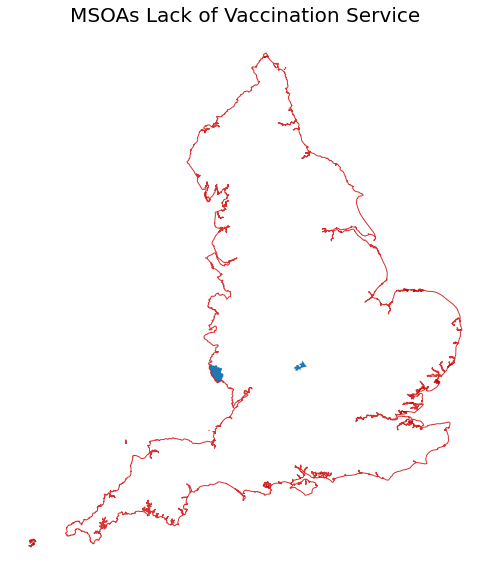

In [ ]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [ ]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60+69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [ ]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca_10",max_cost = 16093.44)
fca.two_stage_fca(name = "2sfca_15",max_cost = 24140.16)
fca.two_stage_fca(name = "2sfca_20",max_cost = 32186.88)
fca.two_stage_fca(name = "2sfca_25",max_cost = 40233.60)
fca.two_stage_fca(name = "2sfca_30",max_cost = 48280.32)

### E2SFCA

#### Set distance decay weight using gaussian function.

In [ ]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# 用3σ原理解释参数的选择 (According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0)
gaussian_10 = weights.gaussian(sigma =5364.48)
gaussian_15 = weights.gaussian(sigma =8064.72)
gaussian_20 = weights.gaussian(sigma =10728.96)
gaussian_25 = weights.gaussian(sigma =13411.20)
gaussian_30 = weights.gaussian(sigma =16093.44)

fca.enhanced_two_stage_fca(name = "E2sfca_10", weight_fn = gaussian_10)
fca.enhanced_two_stage_fca(name = "E2sfca_15", weight_fn = gaussian_15)
fca.enhanced_two_stage_fca(name = "E2sfca_20", weight_fn = gaussian_20)
fca.enhanced_two_stage_fca(name = "E2sfca_25", weight_fn = gaussian_25)
fca.enhanced_two_stage_fca(name = "E2sfca_30", weight_fn = gaussian_30)

### 3SFCA

In [ ]:
fca.three_stage_fca(name = "3sfca_10", weight_fn = gaussian_10)

In [ ]:
fca.three_stage_fca(name = "3sfca_15", weight_fn = gaussian_15)

In [ ]:
fca.three_stage_fca(name = "3sfca_20", weight_fn = gaussian_20)

In [ ]:
fca.three_stage_fca(name = "3sfca_25", weight_fn = gaussian_25)

In [ ]:
fca.three_stage_fca(name = "3sfca_30", weight_fn = gaussian_30)

## See the result

In [ ]:
fca.access_df.head()

# Show the accessibility/vaccination rate result on map

In [ ]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_10_supply_value": "2sfca_10", "2sfca_15_supply_value": "2sfca_15", 
                                    "2sfca_20_supply_value": "2sfca_20", "2sfca_25_supply_value": "2sfca_25","2sfca_30_supply_value": "2sfca_30",
                                   "E2sfca_10_supply_value": "E2sfca_10", "E2sfca_15_supply_value": "E2sfca_15", 
                                    "E2sfca_20_supply_value": "E2sfca_20", "E2sfca_25_supply_value": "E2sfca_25","E2sfca_30_supply_value": "E2sfca_30",
                                   "3sfca_10_supply_value": "3sfca_10", "3sfca_15_supply_value": "3sfca_15", 
                                    "3sfca_20_supply_value": "3sfca_20", "3sfca_25_supply_value": "3sfca_25","3sfca_30_supply_value": "3sfca_30"})

## Add vaccination population data and calculate vaccination rate

In [ ]:
# Read the vaccination population data
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_3_7.csv'
vaccination_pop = pd.read_csv(url)

In [ ]:
vaccination_pop['60-69'] = vaccination_pop['over60_64'] + vaccination_pop['over65_69']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')

In [ ]:
MSOA_fca['vaccination_percentage_for60+69'] = MSOA_fca['60-69']/MSOA_fca['pop60+69']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_60+69']= np.where(MSOA_fca['vaccination_percentage_for60+69']>1, 1, MSOA_fca['vaccination_percentage_for60+69'])

## Exclude London regions

In [ ]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [ ]:
London

In [ ]:
test = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
MSOA_fca =test[pd.isnull(test).any(axis=1)]
MSOA_fca

## Use min-max normalization to normalize the accessibility score

In [ ]:
MSOA_fca['2sfca_10_normalized'] = (MSOA_fca['2sfca_10']-MSOA_fca['2sfca_10'].min())/(MSOA_fca['2sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['2sfca_15_normalized'] = (MSOA_fca['2sfca_15']-MSOA_fca['2sfca_15'].min())/(MSOA_fca['2sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['2sfca_20_normalized'] = (MSOA_fca['2sfca_20']-MSOA_fca['2sfca_20'].min())/(MSOA_fca['2sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['2sfca_25_normalized'] = (MSOA_fca['2sfca_25']-MSOA_fca['2sfca_25'].min())/(MSOA_fca['2sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['2sfca_30_normalized'] = (MSOA_fca['2sfca_30']-MSOA_fca['2sfca_30'].min())/(MSOA_fca['2sfca_30'].max()-MSOA_fca['2sfca_30'].min())


MSOA_fca['E2sfca_10_normalized'] = (MSOA_fca['E2sfca_10']-MSOA_fca['E2sfca_10'].min())/(MSOA_fca['E2sfca_10'].max()-MSOA_fca['E2sfca_10'].min())
MSOA_fca['E2sfca_15_normalized'] = (MSOA_fca['E2sfca_15']-MSOA_fca['E2sfca_15'].min())/(MSOA_fca['E2sfca_15'].max()-MSOA_fca['E2sfca_15'].min())
MSOA_fca['E2sfca_20_normalized'] = (MSOA_fca['E2sfca_20']-MSOA_fca['E2sfca_20'].min())/(MSOA_fca['E2sfca_20'].max()-MSOA_fca['E2sfca_20'].min())
MSOA_fca['E2sfca_25_normalized'] = (MSOA_fca['E2sfca_25']-MSOA_fca['E2sfca_25'].min())/(MSOA_fca['E2sfca_25'].max()-MSOA_fca['E2sfca_25'].min())
MSOA_fca['E2sfca_30_normalized'] = (MSOA_fca['E2sfca_30']-MSOA_fca['E2sfca_30'].min())/(MSOA_fca['E2sfca_30'].max()-MSOA_fca['E2sfca_30'].min())

MSOA_fca['3sfca_10_normalized'] = (MSOA_fca['3sfca_10']-MSOA_fca['3sfca_10'].min())/(MSOA_fca['3sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['3sfca_15_normalized'] = (MSOA_fca['3sfca_15']-MSOA_fca['3sfca_15'].min())/(MSOA_fca['3sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['3sfca_20_normalized'] = (MSOA_fca['3sfca_20']-MSOA_fca['3sfca_20'].min())/(MSOA_fca['3sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['3sfca_25_normalized'] = (MSOA_fca['3sfca_25']-MSOA_fca['3sfca_25'].min())/(MSOA_fca['3sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['3sfca_30_normalized'] = (MSOA_fca['3sfca_30']-MSOA_fca['3sfca_30'].min())/(MSOA_fca['3sfca_30'].max()-MSOA_fca['2sfca_30'].min())


#MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
#MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

In [ ]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop60+69','60-69',
                     'vaccination_rate_60+69',
                     '2sfca_10_normalized','2sfca_15_normalized','2sfca_20_normalized','2sfca_25_normalized','2sfca_30_normalized',
                     'E2sfca_10_normalized','E2sfca_15_normalized','E2sfca_20_normalized','E2sfca_25_normalized','E2sfca_30_normalized',
                     '3sfca_10_normalized','3sfca_15_normalized','3sfca_20_normalized','3sfca_25_normalized','3sfca_30_normalized',
                     'geometry']]

In [ ]:
# Export result data
MSOA_fca.to_csv('fca_result_exclude_London.csv',index=False)
MSOA_fca.to_file("fca_result_exclude_London.gpkg", driver="GPKG")

# Read data for plotting (generated above)

In [ ]:
MSOA_fca = gpd.read_file('fca_result_exclude_London.gpkg')
MSOA_fca = MSOA_fca.to_crs('epsg:27700')

In [ ]:
MSOA_fca.shape

In [ ]:
MSOA_fca.describe()

## Map plot code

In [ ]:
# function for scale bar
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [ ]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [ ]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [ ]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [ ]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

## Accessibility (When the service radius is 10/15/20/25/30 miles driving distance)

In [ ]:
def access_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram( fig,ax = ax, 
                y = MSOA_fca[column], breaks = q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

### 2SFCA

In [ ]:
# 10 miles
access_break('2sfca_10_normalized')
#plt.savefig('figure/2sfca_10_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 15 miles
access_break('2sfca_15_normalized')
#plt.savefig('figure/2sfca_15_exclude', dpi=600,bbox_inches='tight')

In [ ]:
#20 miles
access_break('2sfca_20_normalized')
plt.savefig('figure/2sfca_20_exclude', dpi=600,bbox_inches='tight')

In [ ]:
#25 miles
access_break('2sfca_25_normalized')
plt.savefig('figure/2sfca_25_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 30 miles
access_break('2sfca_30_normalized')
plt.savefig('figure/2sfca_30_exclude', dpi=600,bbox_inches='tight')

### E2SFCA

In [ ]:
# 10 miles
access_break('E2sfca_10_normalized')
plt.savefig('figure/E2sfca_10_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 15 miles
access_break('E2sfca_15_normalized')
plt.savefig('figure/E2sfca_15_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 20 miles
access_break('E2sfca_20_normalized')
plt.savefig('figure/E2sfca_20_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 25 miles
access_break('E2sfca_25_normalized')
plt.savefig('figure/E2sfca_25_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 30 miles
access_break('E2sfca_30_normalized')
plt.savefig('figure/E2sfca_30_exclude', dpi=600,bbox_inches='tight')

### 3SFCA

In [ ]:
# 10 miles
access_break('3sfca_10_normalized')
plt.savefig('figure/3sfca_10_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 15 miles
access_break('3sfca_15_normalized')
plt.savefig('figure/3sfca_15_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 20 miles
access_break('3sfca_20_normalized')
plt.savefig('figure/3sfca_20_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 25 miles
access_break('3sfca_25_normalized')
plt.savefig('figure/3sfca_25_exclude', dpi=600,bbox_inches='tight')

In [ ]:
# 30 miles
access_break('3sfca_30_normalized')
plt.savefig('figure/3sfca_30_exclude', dpi=600,bbox_inches='tight')

## Vaccination Rate

In [ ]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)
    

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(fig, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [ ]:
pop_rate_break('vaccination_rate_60+69')
plt.savefig('figure/vaccination_rate_exclude', dpi=600,bbox_inches='tight')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA
#### 10mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 15 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 20 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 25 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 30 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

### E2SFCA

#### 10 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 15 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 20 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 25 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 30 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

### 3SFCA

#### 10 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 15 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 20 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 25 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

#### 30 mile

In [ ]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])